In [1]:
from myst_nb import glue

# What is an inverse problem

Mathematical models and data play a big role in modern science and engineering. The field of inverse problems bridges these two and studies if and how one can infer model parameters from relevant observations. A prominent example is the famous black hole image, shown in figure {numref}`blackhole`, that was constructed by merging data from various telescopes {cite}`akiyama2019first`.

```{figure} ./images/what_is/blackhole.png
---
height: 150px
name: blackhole
---
Depiction of a black hole as reconstructed from data recorded by the Event Horizon Telescope.
```

A promiment subfield of inverse problems is that of imaging, with applications in chemistry, biology and medicine. Various methods for imaging have been developed over the previous four decades and have been partly made available for clinical use. On the other hand, to a large extent, those techniques function less automatically than movies or photography. Particularly, in in-vivo imaging there are still many open questions, respectively in most cases there is still much room for improvements. Amongst other things, this concerns all areas of natural sciences, e.g. physics for the design of detectors or lasers, chemistry for the design of tracers in molecular imaging and last, but not least, computer science and mathematics for the reconstruction and automatic analysis of images.

In this course we give an overview of the main mathematical techniques and results underlying inverse problems, including functional analysis, calculus of variations, Bayesian statistics and numerical optimization. Alongside the theory we treat several prominent applications of inverse problems.

## Applications

### Image processing

Images are of great importance in many applications, ranging from microscopy, medicine, to astronomy. In all these applications, the recorded images are distorted or corrupted version of the ideal image. Some examples are shown in figure. The inverse problem consists of reconstructing the idealized image from the measured one.

We can think of a (digital) image as an two dimensional array of pixels where each element could, for example, represent the gray value of the corresponging pixel. A color image could be represented by a tensor representing the RGB intensities for each pixel. Alternatively, we can think of an idealized image as a (vector-valued) function on a bounded domain (say, the unit square).

A mathematical model for the observed image should model the process by which the image was obtained. This often involves convolving the image with a filter and adding noise. For example, for a digital image with pixel values $u_{ij}$, the measured image is given by
\begin{equation}
f_{ij} = \sum_{i,j} k_{i-i,j-j}u_{ij},
\end{equation}
where $k_{ij}$ is the filter. Representing the image as a function, we may have
\begin{equation}
f(x) = \int_{\Omega} k(x-x')u(x)\mathrm{d}x',
\end{equation}
where $\Omega \subset \mathbb{R}^2$ is the image domain and $k$ is the convolution kernel or *point spread function*.

The resulting inverse problem is to undo the convolution. In some cases, $k$ may not be known perfectly, in which case it is called *blind deconvolution*. Other image-related inverse problems include *denoising*, where a noisy version of the image is measured, and *inpainting*, where a significant part of the pixels are missing. Some examples are shown in {numref}`image-deblurring` and {numref}`image-inpainting`. More details in inverse problems of this type are treated in chapter \ref{ch:deconvolution}

In [4]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from skimage.restoration import inpaint

# load test image and convert to gray-scale
astro = color.rgb2gray(data.astronaut())

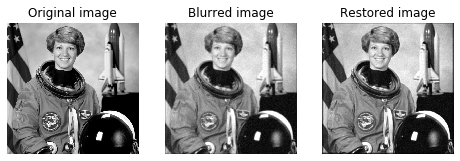

In [5]:
## image deblurring

# define blurring kernel (pointspread function)
psf = np.ones((5, 5)) / 25

# convolve image with kernel
astro_blur = conv2(astro, psf, 'same')
astro_blur += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
astro_restored = restoration.richardson_lucy(astro_blur, psf, iterations=10)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro, vmin=0, vmax=1)
ax[0].set_title('Original image')

ax[1].imshow(astro_blur,vmin=0, vmax=1)
ax[1].set_title('Blurred image')

ax[2].imshow(astro_restored, vmin=0, vmax=1)
ax[2].set_title('Restored image')

plt.show()
glue("image-deblurring", fig, display=False)

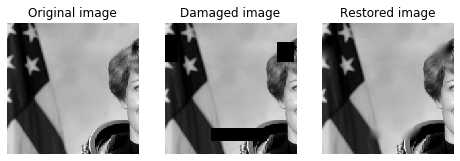

In [6]:
## image inpainting

# Create mask with three defect regions: left, middle, right respectively
mask = np.zeros((200,200))
mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1

# remove parts of the image
astro_defect = astro[0:200, 0:200].copy()
astro_defect[np.where(mask)] = 0

# inpaint
astro_inpainted = inpaint.inpaint_biharmonic(astro_defect, mask, multichannel=False)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro[0:200, 0:200], vmin=0, vmax=1)
ax[0].set_title('Original image')

ax[1].imshow(astro_defect,vmin=0, vmax=1)
ax[1].set_title('Damaged image')

ax[2].imshow(astro_inpainted, vmin=0, vmax=1)
ax[2].set_title('Restored image')

plt.show()
glue("image-inpainting", fig, display=False)

```{glue:figure} image-deblurring
:figwidth: 300px
:name: "image-deblurring"

An example of image deblurring. Do you think we would ever be able to fully recover the original image?
```

```{glue:figure} image-inpainting
:figwidth: 300px
:name: "image-inpainting"

An example of image inpainting. Do you think we would ever be able to fully recover the original image?
```

### X-ray tomography

A CT-scanner is a common tool for medical diagonisis, providing detailed images of the anatomy of a patient. An example is shown in {numref}`ModernCT`. In other applications, such as materials science, similar techniques are being used to obtain three-dimensional reconstructions of the inner structure of objects.

```{figure} ./images/what_is/ModernCT.png
---
height: 150px
name: ModernCT
---
Modern CT scanner (left). Slice of high resolution CT scan of a patient's lung (right). Source for both: Wikimedia Commons
```

In this case $u$, represents the density of the object, which may in turn be thought of as an image. Different from the previous section is the relation to the measurements. A usefull model for x-ray measurements turns out to be the *Radon transform*, which transforms the image $u$ to a *sinogram* $f$ by taking line-integrals along straight lines:
\begin{equation}
f(s,\theta) = \int u(s + n(\theta)) \mathrm{d}t.
\end{equation}
An example of an image and its corresponding sinogram are shown in figure {numref}`walnut`. It is clear that the sinogram itself is not directly suited for interpration and we have to solve the inverse problem to get a usefull image.

```{figure} ./images/what_is/walnut.png
---
height: 150px
name: walnut
---
Two-dimensional slice through a walnut and the corresponding sinogram.
```

### Magnetic resonance imaging

Magnetic resonance imaging (MRI) is another imaging modality for clinical diagnoses. As oppossed to CT, MRI does not rely on ionizing radiation and is hence considered much safer. A disadvantage of MRI is that the time needed for a scan is much longer than for CT.

Here, $u$, is related to the proton density of the tissue and can be interpreted as an image. The physics behind the measurement process are quite complicated, but for most practical settings a usefull model is based on the \emph{Fourier transform} of $u$:

$$
\widehat{u}(\xi) = \int u(x)e^{\imath \xi\cdot x}\mathrm{d}x.
$$

The measurements $f$ are a finite set of samples of the spectrum $\widehat{u}$:

$$
f_i = \int u(x)e^{\imath \xi_i\cdot x}\mathrm{d}x.
$$

Note that when a fully sampled spectrum is available, we can easily retrieve $u$ via the *inverse Fourier transform*

$$
u(x)= \int \widehat{u}(\xi) e^{-\imath \xi\cdot x}\mathrm{d}\xi.
$$

The challenge here lies in retrieving $u$ from a limited set of samples. As the time needed for a scan is proportional to the number of samples acquired, much research is being done on devising methods to recover images from undersampled Fourier measurements.

### Seismic inversion

In seismic inversion, the goal is to infer physical properties of the subsurface from seismic measurements. Here, $u$ represents (for example) the elastic material parameters of the rock and the measurements are time series recorded by seismographs. A typical experimantal setup is depicted in {numref}`seismic_acquisition`. A typical image resulting from such data is shown in {numref}`seismic_image`.

```{figure} ./images/what_is/Diagram_of_a_marine_seismic_survey.png
---
height: 150px
name: seismic_acquisition
---
A typical seismic acquisition setup.
```

```{figure} ./images/what_is/seismic_image.jpg
---
height: 150px
name: seismic_image
---
A typical seismic image depicting various earth layers.
```

The simplest example is when the underlying physics can be described by a simple scalar wave equation:

$$
w_{tt}(t,x) - u(x) \nabla w(t,x) = q(t,x), \quad x \in\Omega, \quad t\in [0,T]
$$

where $w(t,x)$ denotes the \emph{wavefield}, $u(x)$ is related the soundspeed and density of the medium and $q$ is a source term. The measurements are given by

$$
f_i(t) = w(t,x_i), \quad i \in \{1, 2, \ldots, m\}.
$$

The inverse problem consists of retrieving $u$ from the measurements $\{f_i\}_{i=0}^m$, given $q$ In contrast to the previous examples, the relation between $u$ and $f$ is no longer linear, nor does $u$ directly constitute an image (altough it can be visualized as in {numref}`seismic_image`).

## Anatomy of an inverse problems

We can abstractly formulate an inverse problem as finding a solution, $u \in \mathcal{U}$, of the operator equation
```{math}
:label: ip
K(u) = f,
```
where $K$ is called the *forward opertor*; $u$ is the *image* or *parameter* and $f \in \mathcal{F}$ are the measurements. The forward operator, $K : \mathcal{U} \rightarrow \mathcal{F}$, is a model of the underlying (physical) process and simulates the measurements for given $u$. It could represent for example an integral operator, a matrix, or a set of algebraic equations.
The image/parameters, $u$, are a mathematical description of the quantity of interest. It could for example be a function or a vector. The measurements, $f$, are a mathematical representation of the measured data. For the purposes of analysis, we may think of this a function, but in practice measurements are always a discrete quantity.

For the purposes of this course, we will assume that $\mathcal{U}$ and $\mathcal{F}$ are Banach spaces so we can measure distances between different sets of images/parameters and different sets of measurements.

An important notion in inverse problems is *ill-posedness*. We call a problem *ill-posed* if it is not *well-posed*:

```{admonition} Definition: *Well-posedness according to Hadamard*
:class: important

The equation $K(u) = f$ is well-posed if all three criteria are met:

* **Existence.** There exists at least one $u$ for which $K(u) = f$
* **Uniqueness.** There is exactly one $u$ for which $K(u) = f$
* **Stability.** The solution depends continuously on the data, i.e., there is a constant $C < \infty$ such that $\|u - u'\| \leq C \|f - f'\|$ where $K(u) = f$ and $K(u') = f'$.
```

It may seem strange that equation {eq}`ip` may not have a solution. After all, are the measurements not the result of the forward opertor applied to some ground-truth $u^*$? We need to keep in mind here that $K$ is only a *model* for the underlying process. In reality, the measurements may include *modelling errors* and *measurement errors*. An often used model to reflect this is the *additive noise model*

$$
f^{\delta} = Ku^* + e,
$$

where $e$ represents the combined measurement and modelling error with $\|e\| \leq \delta$. If we find a $u$ for which $Ku^{\delta} = f^{\delta}$, we can ask ourselves how big the *backward error* $\|u^{\delta} - u^*\|$ is with respect to the *forward error* $\|e\| = \delta$. In practice we call a problem ill-posed if a small error in the data can cause a large error in the reconstruction.

## Motivating examples

### Rootfinding
Given a continuous function $K : \mathbb{R} \rightarrow \mathbb{R}$, and $f \in \mathbb{R}$ find $u$ such that $K(u) = f$. The inverse function theorem tells us that
the inverse of $K$ exists (at least locally) if $K$ is continuously differentiable at $u$ with $K'(u)\not= 0$. The solution is in this case give by $u = K^{-1}(f)$. For sensitivity we consider $K(u) - K(v) = f - g$, leading to

$$
u - v = K^{-1}(f) - K^{-1}(g) = \left(K^{-1}\right)'(\xi)(f-g).
$$

We can thus derive the error bound

$$
|u - v| \leq C |f - g|,
$$

with

$$
C = \sup_{\xi} |\left(K^{-1}\right)'(\xi)| = \sup_{\xi} |\left(K'(\xi)\right)^{-1}|.
$$

We conclude that the problem of finding a root of $K(u) - f$ is ill-posed when the derivative of $K$ is small near the root.

### Matrix inversion
One of the most simple (class of) inverse problems that arises from (numerical) linear algebra is the solution of linear systems. These can be written in the form of {eq}`ip` with $u \in \mathbb{R}^n$ and $f \in \mathbb{R}^n$ being $n$-dimensional vectors with real entries and $K \in \mathbb{R}^{n \times n}$ being a matrix with real entries. We further assume $K$ to be a symmetric, positive definite matrix. In that case we know from the spectral theory of symmetric matrices that there exist eigenvalues $\lambda_1 \leq \lambda_2 \leq \cdots \leq \lambda_n > 0$ and corresponding eigenvectors $k_j \in \mathbb{R}^n$ for $j \in \{ 1,\cdots,n \}$ such that $K$ can be written as

$$
K = \sum_{j=1}^n \lambda_k k_j k_j^{\top}.
$$

Under these conditions, we have a matrix $K$, which has full rank, i.e. it is invertible, and *existence* as well as *uniqueness* of a solution of {eq}`ip` is guaranteed. Regarding *stability*, however, it is well known from numerical linear algebra that a small perturbation of $f$ may lead to large pertubation of the corresponding solution if the matrix is *ill-conditioned*. In particular, we have

$$
\frac{\|u - u^\delta\|}{\|u\|} \leq \kappa(K) \frac{\|f - f^\delta\|}{\|f\|},
$$

where $\kappa(K) = \|K^{-1}\|\|K\|$ is called the *condition number* of $K$. Hence, we observe that in the worst case an error in the measured data is amplified by the condition number. A matrix with large $\kappa$ is therefore called *ill-conditioned*.

### Differentiation

Here, we are given a function $f \in C^{1}([0,1])$ with $f(0) = 0$ and want to find $u$ such that $K(u) = f$ with

$$
K(u)(x) = \int_0^x u(x') \mathrm{d}x'.
$$

We immediately find $u(x) = f'(x)$.

For sensitivity, assume that we are given a noisy version of the signal $f^{\delta} = f + n^{\delta}$, with $n^{\delta} \in L^{\infty}([0,1])$. An example of such noise is

$$
n^{\delta}(x) = \delta \sin(x/\delta).
$$

It is not hard to show in this case that the forward error $\|f^{\delta} - f\|_{L^{\infty}([0,1])} \rightarrow 0$ as $\delta \rightarrow 0$ but that the backward error $\|u - u^{\delta}\|_{L^{\infty}([0,1])}$ is constant. In the exercises we will see that the ill-posedness can be alleviated to some extent by demanding more regularity from the noise.

## Solving an inverse problem

### Direct methods
In some special cases we can derive an explicit expression for (an approximation) of the solution of $K(u) = f$. For example, if $K$ represents a quadratic equation in one variable or a system of linear equations. In other cases, we may have an explicit expression for the inverse of a slightly modified forward operator, $\widetilde{K}$. This modified operator arises when the original inverse problem is ill-posed and is replaced by a modified inverse problem $\widetilde{K}(u) = f$ which is well-posed. The hope, in the latter case, is that $\widetilde{K}$ approximates $K$ well for the class of solututions we are looking for.

````{admonition} Example: *Inverting a rank-deficient matrix.*

$$
K = \left(\begin{matrix} 1 & 1\\ 2 & 2 \end{matrix}\right).
$$

Obviously this matrix is singular, so there is no way to usefully define the inverse. However, modifying the matrix slightly

$$
\widetilde{K} = \left(\begin{matrix} 1 + \alpha & 1\\ 2 & 2 + \alpha\end{matrix}\right),
$$

allows us to compute the inverse. Indeed, given $f = K\overline{u}$ with $\overline{u} = (1,2)$ we have $f = (3,6)$. Applying the inverse of $\widetilde{K}$ we get $\widetilde{u} \approx (1,2)$. The corresponding equations are visualized in {numref}`matrix_inversion`.

```{glue:figure} matrix_inversion
:figwidth: 300px
:name: "matrix_inversion"

Original and regularized equations. We see that the regularized equations have a unique solution, but has thereby implicity selected one particular solution of the original system.
```
````



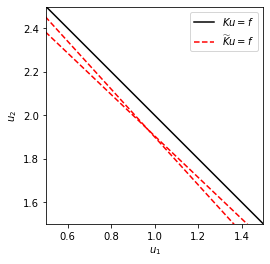

In [7]:
import numpy as np
import matplotlib.pyplot as plt

u1 = np.linspace(0,5,100)
u2 = np.linspace(0,5,100)

fig,ax = plt.subplots(1,1)

alpha = 1e-1

ax.plot(u1,3-u1,'k',label=r'$Ku=f$')
ax.plot(u1,3-(1+alpha)*u1,'r--',label=r'$\widetilde{K}u=f$')
ax.plot(u1,(6-2*u1)/(2+alpha),'r--')

ax.set_xlabel(r'$u_1$')
ax.set_ylabel(r'$u_2$')
ax.set_xlim([0.5,1.5])
ax.set_ylim([1.5,2.5])
ax.set_aspect(1)
ax.legend()
plt.show()
glue("matrix_inversion", fig, display=False)

### Variational methods
Variational methods are a popular and quite generally applicable technique for solving inverse problems. The idea is to replace the original equation $K(u) = f$ by a minimization problem. To do this, one constructs an optimisation problem with a functional consisting of two terms. The first part is the data fidelity and is supposed to ensure that $Ku \approx f$.
The second part is the regularisation functional which incorporates the a-priori information on $u$. Thereby, we obtain a problem of the form

$$
\min_{u \in \mathcal{U}} D(u,f) + \alpha R(u)
$$

where further a-priori information on the class of images $u$, over which we minimise, can be contained, e.g. non-negativity for density images. The data fidelity term $D$ should be constructed in such a way, that $D$ attains its minimum (often normalised at zero) if the data are reconstructed exactly. The regularisation functional should be constructed in such a way, that $R$ attains a small value if the image matches the a-priori information very well, and a very large value, if the image does not fit to the available a-priori information. As a result, such images will hardly become a minimum of the functional $J$. The parameter $\alpha$ weights the two parts of the functional. For very small $\alpha$ primarily data gets reconstructed, whereas with increasing $\alpha$ the regularisation gains in importance in this ratio, which is particularly essential if measurement errors or noise can be expected.

````{admonition} Example: *Solving a quadratic equation.*

We want to illustrate this principle by a simple example. We search for a *small* solution of the following quadratic equation

$$
	u^2 - f_1 u + f_2 = 0,
$$

with the given data $f_1=1.1$ and $f_2 = .1$.
With the solution formula for quadratic equations we obtain two solutions

$$
	u_1 = 0.1 \qquad \text{and} \qquad u_2 = 1.
$$

With our a-priori information of a *small* solution we obviously choose the solution $u_1$. However, this is only possible in this specific case, because we can indeed compute all solutions. For more complicated problems this is not possible anymore. Moreover, we have to face measurement errors, such that we should better compute an approximate solution in a robust manner than many exact solutions. A variational approach can be realised for this example by minimizing the functional

$$
	J(u) = (u^2 - f_1 u + f_2)^2 + \alpha u^2.
$$

For $\alpha$ large, this functional has a global minimum around $u = 0$, while for $\alpha$ small, it still has multiple minima. However, for suitable $\alpha$, we have a global minimum at $u \approx 0.1$ and minimzing the regularized problem yields (an approximation of) the smaller solution, as illustrated in {numref}`quadratic`.

```{glue:figure} quadratic
:figwidth: 300px
:name: "quadratic"

Original quadratic equation and functional to be minimized. We see that mimizing the functional picks out one of the two solutions.
```
````

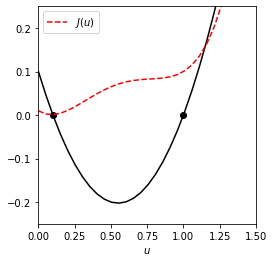

In [8]:
import numpy as np
import matplotlib.pyplot as plt

u = np.linspace(0,5,100)

fig,ax = plt.subplots(1,1)

alpha = 1e-1

ax.plot(u,u**2 - 1.1*u + 0.1,'k')
ax.plot(0.1,0,'ko')
ax.plot(1,0,'ko')
ax.plot(u,(u**2 - 1.1*u + 0.1)**2 + alpha*(u**2),'r--',label=r'$J(u)$')
ax.set_xlabel(r'$u$')
ax.set_xlim([0,1.5])
ax.set_ylim([-0.25,.25])
ax.set_aspect(3)
ax.legend()
plt.show()
glue("quadratic", fig, display=False)

## Excercises

### Matrix inversion I
We want to solve a system of linear equations $Ku = f$ with :

1. $$K = \left(\begin{matrix} 1 & 2 \\ 2 & 1\end{matrix}\right), \quad f = \left(\begin{matrix} 1 \\ 1 \end{matrix}\right),$$

2. $$K = \left(\begin{matrix} 1 & 1 \\ 1 & 1.001\end{matrix}\right), \quad f = \left(\begin{matrix} 1 \\ 1 \end{matrix}\right),$$

3. $$K = \left(\begin{matrix} 1 & 1 \\ 2 & 1 \\ 2 & 2\end{matrix}\right), \quad f = \left(\begin{matrix} 1 \\ 1 \\ 1\end{matrix}\right),$$

4. $$K = \left(\begin{matrix} 1 & 1 \\ 2 & 1 \\ 2 & 2\end{matrix}\right), \quad f = \left(\begin{matrix} 1 \\ 2 \\ 2\end{matrix}\right),$$

5. $$K = \left(\begin{matrix} 1 & 2 & 1\\ 2 & 0 & 2\end{matrix}\right), \quad f = \left(\begin{matrix} 1 \\ 1 \end{matrix}\right),$$

6. $$K = \left(\begin{matrix} 1 & 0 \\ 0 & 0\end{matrix}\right), \quad f = \left(\begin{matrix} 0 \\ 1 \end{matrix}\right),$$

Is the problem ill-posed? Why? You can easily compute eigenvalues and vectors numerically, as shown in the example below.

In [1]:
import numpy as np

K = np.array([[1,2],[2,1]])
f = np.array([1,1])

l, V = np.linalg.eig(K)
print("The eigenvalues are:", l)
print("The eigenvectors are:",V[:,0], V[:,1])

The eigenvalues are: [ 3. -1.]
The eigenvectors are: [0.70710678 0.70710678] [-0.70710678  0.70710678]


### Matrix inversion II

Given a symmetric, positive definite matrix $K \in \mathbb{R}^{n\times n}$ we want to solve $Ku = f$. Such a matrix can be decomposed as
$$K = \sum_{i=1}^n \lambda_i k_ik_i^T,$$
where $\lambda_1\geq \lambda_2 \geq \ldots \geq \lambda_n > 0$ are the eigenvalues and $k_i$ denote the eigenvectors. Such a matrix has an inverse given by 
$$K^{-1} = \sum_{i=1}^n \lambda_i^{-1} k_ik_i^T.$$

To study the well-posedness of the equation we want to bound the *backward error* $\|u - u^\delta\|_2$ in terms of the *forward error* $\|f - f^{\delta}\|_2$ where $Ku = f$ and $Ku^{\delta} = f^\delta$.

1. Show that $$\|u - u^\delta\|_2 \leq \lambda_n^{-1} \|f - f^{\delta}\|_2.$$
2. Show that the *relative error* is bounded by
$$\frac{\|u - u^\delta\|_2}{\|u\|_2} \leq \lambda_1\lambda_n^{-1} \frac{\|f - f^{\delta}\|_2}{\|f\|_2}.$$
3. Compute the condition numbers for the matrices 1, 2 and 6 in the previous excercise; what do you notice?

### Differentiation I

We are given a function $f \in C^1([0,1])$ with $f(0) =0$ and want to solve the following inverse problem

$$ Ku(x) \equiv \int_0^{x} u(x')\mathrm{d}x' = f(x), \quad \text{for} \quad x \in [0,1].$$

It is readily verified that we can find a (unique) solution by differentiation: $u(x) = f'(x)$. To study well-posedness of the problem, we consider *noisy* measurements $f^{\delta}(x) = f(x) + \delta\sin(k x /\delta)$ for fixed  arbitrary $k$ and small $\delta > 0$.

1. Show that the *forward error* $f - f^{\delta}$ is bounded in the $L^{\infty}$ norm, in particular $\|f - f^{\delta}\|_{L^{\infty}([0,1])} = \delta$.
2. Show that the *backward error* $u - u^{\delta}$ can be arbirarily large, even if $\delta\downarrow 0$: $\|u - u^{\delta}\|_{L^{\infty}([0,1])} = k$.

Recall that
$$\|g\|_{L^{\infty}([0,1])} = \sup_{x\in[0,1]} |g(x)|.$$

This shows that the problem is *ill-conditioned*; a small forward error does not guarantee a small backward error, implying that the inverse map is not continuous.

### Differentiation II

The analysis in the previous exercise depends crucially on the type of noise we allow. If we assume that $n^{\delta} = f - f^{\delta}$ is bounded by $\delta$ in a different norm, we can get a well-posed problem.

1. Assuming that $\|n^{\delta}\|_{C^1([0,1])} = \delta$, show that $\|u - u^{\delta}\|_{L^{\infty}([0,1])} \rightarrow 0$ when $\delta \rightarrow 0$.

2. Can you come up with a type of noise that obeys the assumed bound?

Recall that
$$\|g\|_{C^{1}([0,1])} = \sup_{x\in[0,1]} |g(x)| + \sup_{x\in[0,1]} |g'(x)|.$$